# Unsupervised Classification Analysis
## Marc Boulet
## Team Transparency, CSE 6242 Spring 2020


This notebook will take Team Transparency's merged dataset of country features and attempt to rank countries through unsupervised methods:
- k-means clustering  
- hierarchical clustering  
- DBSCAN  
- PCA of grouped attributes

## Recipe
1. Identify and eliminate highly correlated features
2. Transform your data if necessary
3. Hypothesize (in advance!) why things should cluster based on your EDA
4. Use a variety of unsupervised techniques to cluster your data
5. Use validation metrics to provide an unbiased measurement of clustering performance
6. Deliver some actionable insights

## Libraries and data load

In [74]:
# libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
# from sklearn.cluster import DBSCAN
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# load data
merged = pd.read_csv('../data/converted/merged.csv')
df = merged.copy()
df.head()

,year,gii_human_capital,country_iso,gii_domestic_credit,mobile_subscriptions,broadband_subscriptions_per100,gii_ict_services_imports,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,...,gii_wikipedia_edits,gii_ict_access,gii_stem_assessment,poverty_ratio,foreign_investment,total_hospital_density_per_100k,gii_university_industry,gii_innovation_output,gdp_per_capta_usd,global_innovation_index
0,1960,NaN,ABW,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1961,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1962,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1963,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1964,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial data conditioning  

In [3]:
# remove all years prior to 2000
#df.drop(df[df.year < 2000].index, inplace = True)

In [5]:
# calculate feature mean over all years available (using mean to include outlier effects) 
df_mean = df.groupby('country_iso', as_index=False).mean()
# remove year column
df_mean.drop(['year'], axis = 1, inplace = True)

## Feature identification and elimination
- remove all features that have a strong correlation (>0.5)


In [9]:
non_cultural = df_mean[['gii_domestic_credit',
                        'mobile_subscriptions',
                        'broadband_subscriptions_per100',
                        'gii_ict_services_imports',
                        'diversity_ethnicFractionalization',
                        'diversity_linguisticFractionalization',
                        'diversity_religiousFractionalization',
                        'literacy_rate',
                        'electrification',
                        'rural_population',
                        'school_enrollment_tertiary',
                        'gii_rule_of_law',
                        'population',
                        'mortality_rate',
                        'secure_internet_servers',
                        'gii_institutions',
                        'gii_top_level_domains',
                        'gii_research_talent_in_business',
                        'life_expectancy',
                        'ease_of_business',
                        'gii_ict_access',
                        'gii_stem_assessment',
                        'poverty_ratio',
                        'foreign_investment',
                        'total_hospital_density_per_100k',
                        'gii_university_industry',
                        'gdp_per_capta_usd', 
                        ]]


### Economic factors

In [35]:
eco = non_cultural[['gii_domestic_credit',
                    'ease_of_business',                 
                    'foreign_investment',
                    'gdp_per_capta_usd',
                    ]]

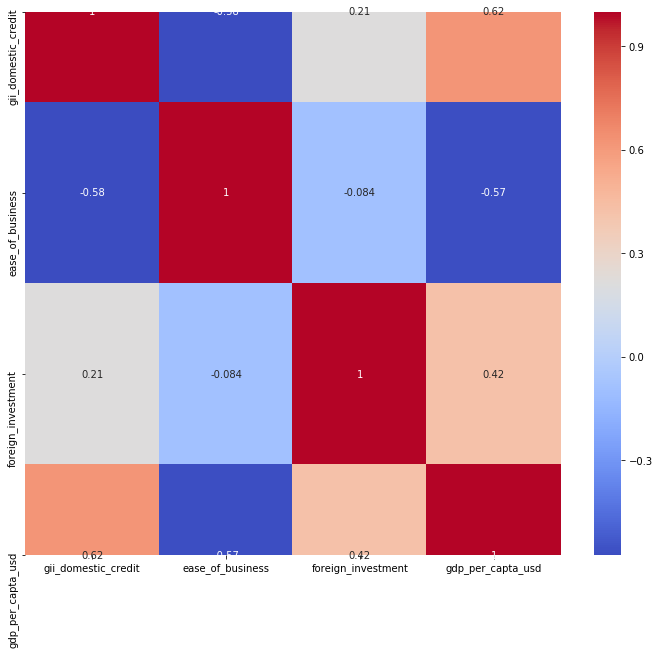

,gii_domestic_credit,ease_of_business,foreign_investment,gdp_per_capta_usd
gii_domestic_credit,1.000000,-0.575369,0.213173,0.619282
ease_of_business,-0.575369,1.000000,-0.084421,-0.566049
foreign_investment,0.213173,-0.084421,1.000000,0.424160
gdp_per_capta_usd,0.619282,-0.566049,0.424160,1.000000


In [70]:
plt.figure(figsize=(12,10))
cor = eco.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
cor

#### Economic factor conclusion:
- keep all factors
- no heavily correlated factors

In [68]:
# remove eliminated factors
#df_mean.drop(['poverty_ratio', 'mortality_rate'], axis = 1, inplace = True)
#df_mean.drop(['poverty_ratio', 'mortality_rate'], axis = 1)

,country_iso,gii_human_capital,gii_domestic_credit,mobile_subscriptions,broadband_subscriptions_per100,gii_ict_services_imports,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,literacy_rate,...,ease_of_business,gii_wikipedia_edits,gii_ict_access,gii_stem_assessment,foreign_investment,total_hospital_density_per_100k,gii_university_industry,gii_innovation_output,gdp_per_capta_usd,global_innovation_index
0,ABW,NaN,NaN,38.400524,14.664502,NaN,0.0000,0.3889,0.4107,97.307103,...,NaN,NaN,NaN,NaN,3.200686,NaN,NaN,NaN,25444.983298,NaN
1,AFG,NaN,NaN,12.360732,0.011756,NaN,0.7693,0.6141,0.2717,30.972840,...,173.0,NaN,NaN,NaN,0.824011,0.37,NaN,NaN,575.652428,NaN
2,AGO,NaN,NaN,11.679964,0.183138,NaN,0.7867,0.7870,0.6276,66.717765,...,177.0,NaN,NaN,NaN,4.331602,NaN,NaN,NaN,4310.757348,NaN
3,ALB,22.7,35.0,31.171650,5.630488,1.5,0.2204,0.0399,0.4719,97.377008,...,82.0,16.0,5.3,415.2,4.359191,1.36,3.3,18.3,4475.868233,30.3
4,AND,NaN,NaN,33.022121,26.791824,NaN,0.7139,0.6848,0.2326,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39559.167382,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,XKX,NaN,NaN,32.302099,NaN,NaN,NaN,NaN,NaN,NaN,...,57.0,NaN,NaN,NaN,6.011548,NaN,NaN,NaN,NaN,NaN
267,YEM,12.5,5.6,13.632878,0.675849,0.4,0.0000,0.0080,0.0023,45.595000,...,187.0,1.1,NaN,NaN,0.927292,2.97,2.2,6.4,1322.945523,14.5
268,ZAF,30.4,147.7,39.606973,1.393860,1.2,0.7517,0.8652,0.8603,89.547812,...,84.0,4.2,5.4,NaN,0.829039,0.67,4.2,22.3,6127.058953,34.0
269,ZMB,1.4,11.2,15.640329,0.079298,0.7,0.7808,0.8734,0.7359,72.222199,...,85.0,0.1,3.1,NaN,3.539640,0.45,2.9,12.7,1554.916338,20.4


### Demographic factors

In [44]:
dem = non_cultural[['diversity_ethnicFractionalization',
                    'diversity_linguisticFractionalization',
                    'diversity_religiousFractionalization',
                    'population',
                    'mortality_rate',
                    'life_expectancy',
                    'poverty_ratio'
                    ]]

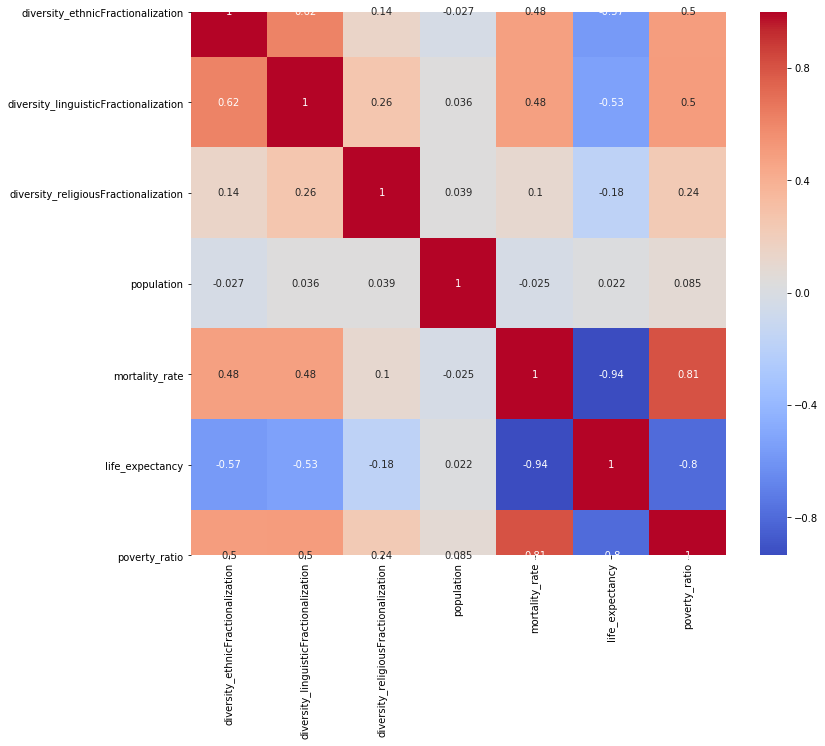

,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,population,mortality_rate,life_expectancy,poverty_ratio
diversity_ethnicFractionalization,1.000000,0.621226,0.139159,-0.027110,0.481270,-0.569092,0.499416
diversity_linguisticFractionalization,0.621226,1.000000,0.259644,0.035559,0.481024,-0.528302,0.501477
diversity_religiousFractionalization,0.139159,0.259644,1.000000,0.039449,0.103313,-0.176155,0.235205
population,-0.027110,0.035559,0.039449,1.000000,-0.025171,0.022459,0.084596
mortality_rate,0.481270,0.481024,0.103313,-0.025171,1.000000,-0.935417,0.809397
life_expectancy,-0.569092,-0.528302,-0.176155,0.022459,-0.935417,1.000000,-0.795225
poverty_ratio,0.499416,0.501477,0.235205,0.084596,0.809397,-0.795225,1.000000


In [45]:
plt.figure(figsize=(12,10))
cor = dem.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [46]:
# number of nulls per feature
dem.isnull().sum(axis=0)

diversity_ethnicFractionalization        65
diversity_linguisticFractionalization    65
diversity_religiousFractionalization     65
population                                8
mortality_rate                           79
life_expectancy                          74
poverty_ratio                            93
dtype: int64

### Demographic factor conclusion
- mortality_rate, life_expectancy, poverty_ratio all highly-correlated (R2 > 0.8)
- remove poverty_ratio and mortality_rate, due to higher nulls than life_expectancy

### Infrastructure factors

In [53]:
inf = non_cultural[['mobile_subscriptions',
                    'broadband_subscriptions_per100',
                    'gii_ict_services_imports',
                    'literacy_rate',
                    'electrification',
                    'rural_population',
                    'school_enrollment_tertiary',
                    'gii_rule_of_law',
                    'secure_internet_servers',
                    'gii_institutions',
                    'gii_top_level_domains',
                    'gii_research_talent_in_business',
                    'gii_ict_access',
                    'gii_stem_assessment',
                    'total_hospital_density_per_100k',
                    'gii_university_industry'                    
                    ]]

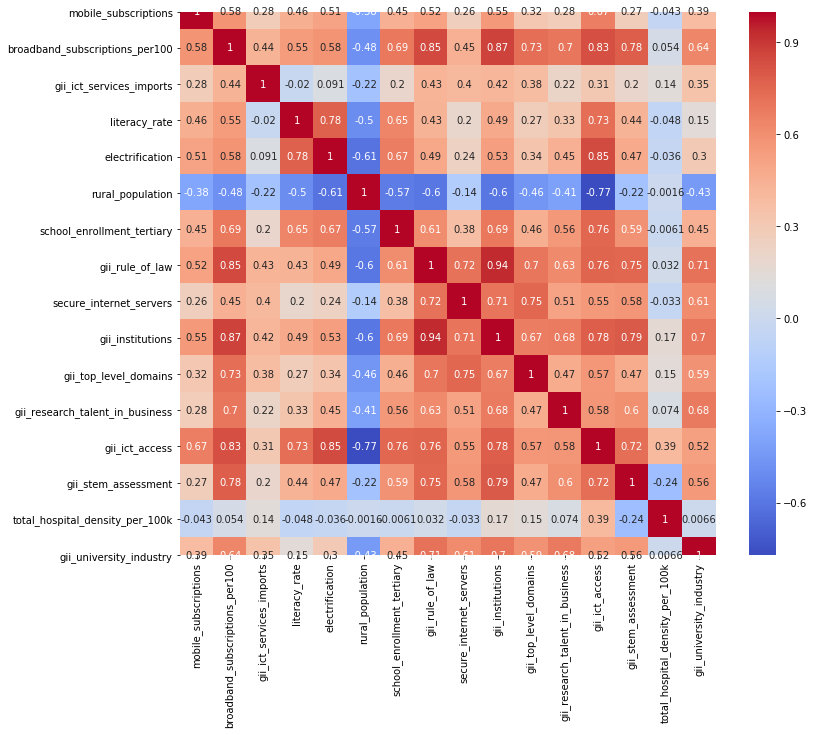

In [57]:
plt.figure(figsize=(12,10))
cor = inf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [56]:
# number of nulls per feature
inf.isnull().sum(axis=0)

mobile_subscriptions                11
broadband_subscriptions_per100      64
gii_ict_services_imports           143
literacy_rate                       65
electrification                     10
rural_population                    69
school_enrollment_tertiary          34
gii_rule_of_law                    142
secure_internet_servers             10
gii_institutions                   142
gii_top_level_domains              142
gii_research_talent_in_business    185
gii_ict_access                     145
gii_stem_assessment                200
total_hospital_density_per_100k    136
gii_university_industry            146
dtype: int64

#### Infrastructure factor conclusion
- broadband_subscriptions_per100, gii_ict_access, gii_institutions, gii_rule_of_law, gii_stem_assessment all highly-correlated (R2 > 0.75)
- keep broadband_subscriptions_per100 only, due to lowest nulls in dataset
- electrification and literacy rate highly correlated (0.78)
- keep electrification

### Cultural factors

In [64]:
cultural = df_mean[['gii_human_capital',
                    'gii_scientific_publications',
                    'rd_in_gdp',
                    'creative_svc_audiovisual',
                    'creative_svc_other_personal_cultural_recreational',
                    'creative_svc_advertising_mktresearch_polling',
                    'creative_svc_architectural_engineering_technical',
                    'creative_svc_personal_cultural_recreational',
                    'creative_svc_research',
                    'gii_creative_services', 
                    'gii_patent_applications',
                    'feature_films_produced',
                    'gii_patent_families',
                    'gii_mobile_apps',
                    'cultural_occupation',
                    'gii_creative_goods',
                    'gii_wikipedia_edits',
                    'gii_innovation_output',
                    ]]

# did not include 'global_innovation_index' in the analysis

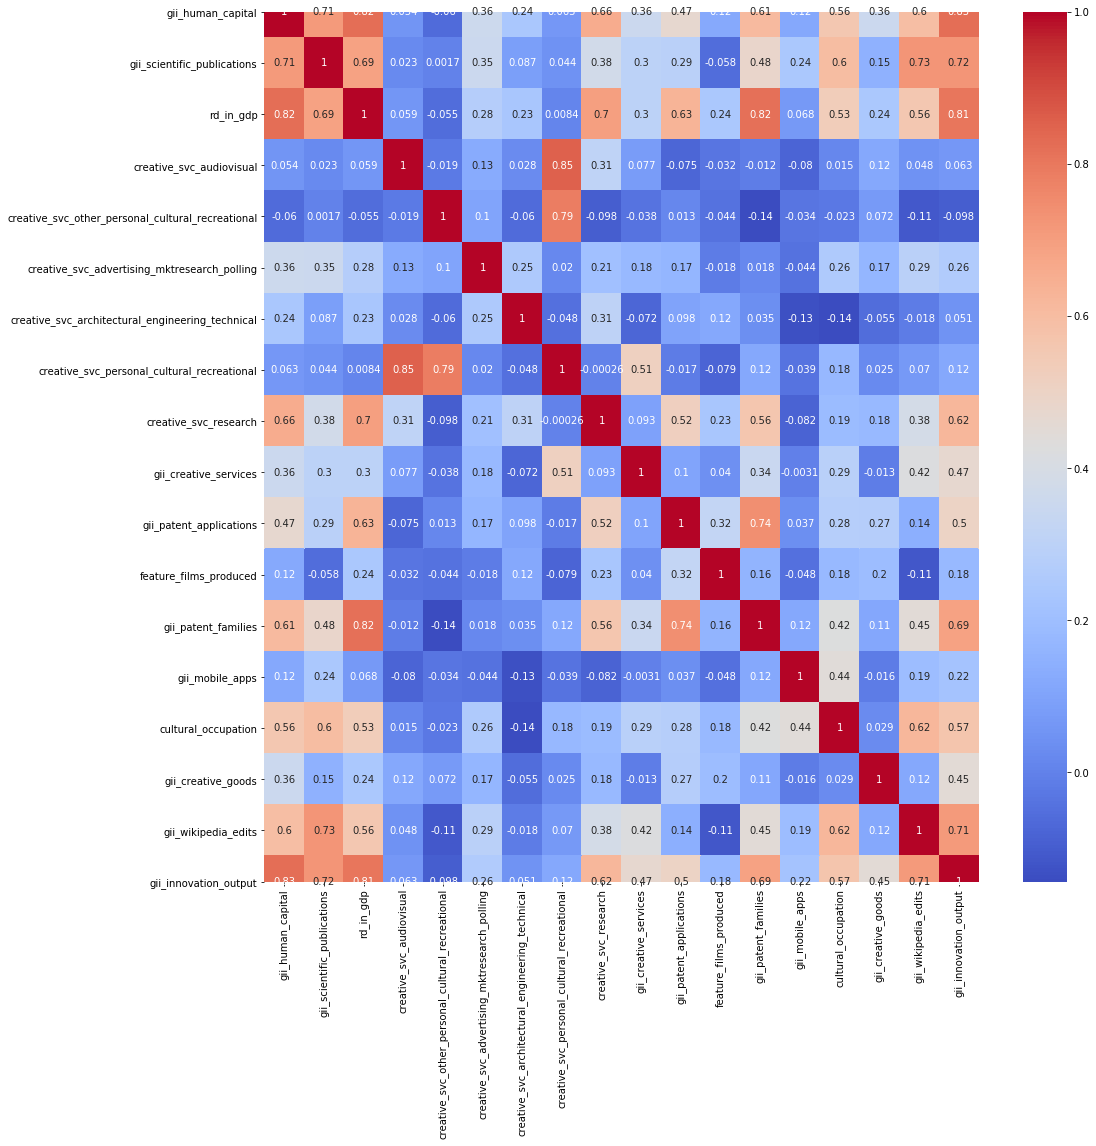

In [66]:
# cultural factor correlation
plt.figure(figsize=(16,16))
cor = cultural.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()
#cor

In [67]:
# number of nulls per feature
cultural.isnull().sum(axis=0)

gii_human_capital                                    142
gii_scientific_publications                          143
rd_in_gdp                                            147
creative_svc_audiovisual                             183
creative_svc_other_personal_cultural_recreational    167
creative_svc_advertising_mktresearch_polling         178
creative_svc_architectural_engineering_technical     192
creative_svc_personal_cultural_recreational          130
creative_svc_research                                199
gii_creative_services                                152
gii_patent_applications                              145
feature_films_produced                               154
gii_patent_families                                  148
gii_mobile_apps                                      173
cultural_occupation                                  202
gii_creative_goods                                   143
gii_wikipedia_edits                                  144
gii_innovation_output          

#### Cultural factor conclusion
- get rid of patent_families (high correlation with rd_in_gdp and gii_patent_applications)
- get rid of gii_innovation_output (high correlation with gii_human_capital and rd_in_gdp)
- get rid of creative_svc_personal_cultural_recreational (high correlation with creative_svc_audiovisual and creative_svc_other_personal_cultural_recreational)


### Prepare dataframe for classification

TODO: remove all highly correlated features

In [59]:
# impute remaining nulls with median feature value
df_fill = df_mean.fillna(df_mean.median(axis = 0))

In [ ]:
# # number of nulls per country
# df_mean.isnull().sum(axis=1)

In [103]:
# Write to .csv file
df_mean.to_csv('../data/converted/df_mean.csv',index=False)

### k-means clustering

In [134]:
df_scaled = df_mean.copy()

# scale numeric features
scaler = StandardScaler()
df_mean.loc[:,df_mean.columns != 'country_iso'] = scaler.fit_transform(df_mean.loc[:,df_mean.columns != 'country_iso'].to_numpy())

,country_iso,gii_human_capital,gii_domestic_credit,mobile_subscriptions,broadband_subscriptions_per100,gii_ict_services_imports,diversity_ethnicFractionalization,diversity_linguisticFractionalization,diversity_religiousFractionalization,literacy_rate,...,gii_wikipedia_edits,gii_ict_access,gii_stem_assessment,poverty_ratio,foreign_investment,total_hospital_density_per_100k,gii_university_industry,gii_innovation_output,gdp_per_capta_usd,global_innovation_index
0,ABW,-0.077106,-0.192876,0.255192,0.820655,-0.148632,-1.638504,0.116395,-0.152594,0.964998,...,-0.320341,0.168832,0.141033,-0.337587,-0.088047,-0.155727,-0.149860,-0.201662,0.470546,-0.137290
1,AFG,-0.077106,-0.192876,-0.992296,-0.855466,-0.148632,1.541264,1.013213,-0.849860,-2.624861,...,-0.320341,0.168832,0.141033,-0.337587,-0.136711,-0.354222,-0.149860,-0.201662,-0.619852,-0.137290
2,AGO,-0.077106,-0.192876,-1.024909,-0.835862,-0.148632,1.613184,1.701757,0.935442,-0.690427,...,-0.320341,0.168832,0.141033,0.832649,-0.064890,-0.155727,-0.149860,-0.201662,-0.456086,-0.137290
3,ALB,-0.796364,-0.732417,-0.091121,-0.212742,0.390220,-0.727519,-1.273435,0.154404,0.968781,...,-0.035498,-0.882555,-2.067482,-0.810863,-0.064325,-0.081292,-0.482744,-0.784720,-0.448847,-0.567272
4,AND,-0.077106,-0.192876,-0.002471,2.207895,-0.148632,1.312278,1.294763,-1.045997,0.301524,...,-0.320341,0.168832,0.141033,-0.337587,-0.110254,-0.155727,-0.149860,-0.201662,1.089384,-0.137290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,XKX,-0.077106,-0.192876,-0.036965,-0.391080,-0.148632,0.012760,-0.106416,0.099726,0.301524,...,-0.320341,0.168832,0.141033,-0.796192,-0.030492,-0.155727,-0.149860,-0.201662,-0.357037,-0.137290
267,YEM,-1.749147,-1.660050,-0.931351,-0.779501,-1.091623,-1.638504,-1.400471,-2.201252,-1.833543,...,-0.678552,0.168832,0.141033,-0.217099,-0.134596,0.362564,-2.313611,-2.119026,-0.587087,-2.454419
268,ZAF,-0.077106,2.823509,0.312990,-0.697368,-0.013919,1.468517,2.013174,2.102736,0.545083,...,-0.544763,-0.810045,0.141033,0.545999,-0.136608,-0.271516,1.015237,-0.336214,-0.376450,-0.125346
269,ZMB,-2.785999,-1.483358,-0.835180,-0.847740,-0.687484,1.588797,2.045829,1.478708,-0.392540,...,-0.721710,-2.477762,0.141033,2.048243,-0.081106,-0.332167,-1.148514,-1.412629,-0.576916,-1.749725


### PCA
#### try pca on cultural and non-cultural datasets

In [ ]:
#plot_pca_variance(pca)